In [201]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import pickle

import numpy as np  
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
import torch
import re
import language_tool_python
from collections import Counter
from PIL import Image
from textblob import TextBlob
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import torch
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import GPT2Tokenizer, GPT2LMHeadModel
from Prog.ModelEvaluator import ModelEvaluator
from Models.HARDVOTING import HardVotingClassifier
from Models.XGBoost import XGBoostClassifier
from Models.KNN import KNNClassifier 
from Models.CNN import CNN,Model_training,load_data,plot_metrics,evaluate_cnn_model
from imblearn.over_sampling import SMOTE
from Models.SVM import SVMClassifier
from Models.LSTM import LSTMClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from plotly import graph_objs as go
from collections import defaultdict
import pandas as pd
from plotly import tools
from plotly.offline import iplot
from palettable.colorbrewer.qualitative import Pastel1_7



In [4]:
from Preprocess.data_cleaning import DataCleaning
from Preprocess.data_visualisation import Data_visualisation
from Embeddings.Bert_Embeddings import BertEmbedding
from Embeddings.Deberta_embed import DebertaEmbedding
from Embeddings.Roberta_Embeddings import RobertaEmbedding


## 1. Data exploration

In [3]:
df = pd.read_csv('C:/Users/iyadh/Desktop/hate_speech/Data/Ethos_Dataset_Binary.csv', sep=';')

In [4]:
df.head(4)

comment  isHate
0          You should know women's sports are a joke     1.0
1    You look like Sloth with deeper Down’s syndrome     1.0
2  You look like Russian and speak like Indian. B...     1.0
3               Women deserve to be abused, I guess.     1.0

In [5]:
df.shape

(998, 2)

In [6]:
df.columns

Index(['comment', 'isHate'], dtype='object')

In [7]:
df= df.rename(columns={'isHate': 'class'})

In [8]:
# Check class value counts (1 hate true , 2 neutral ,0 non hate)
#Were going to work with 1 and 0
df['class'].value_counts()

class
0.000000    354
1.000000    163
0.166667    106
0.833333    100
0.333333     80
0.500000     74
0.666667     70
0.250000      6
0.750000      6
0.857143      3
0.903846      2
0.400000      2
0.018868      2
0.966667      1
0.954545      1
0.973333      1
0.978261      1
0.983871      1
0.983607      1
0.945455      1
0.937500      1
0.678571      1
0.821429      1
0.603448      1
0.722222      1
0.846154      1
0.849057      1
0.296875      1
0.302326      1
0.530612      1
0.200000      1
0.111111      1
0.103448      1
0.160714      1
0.152542      1
0.038961      1
0.090909      1
0.037736      1
0.031746      1
0.029851      1
0.030303      1
0.026316      1
0.016393      1
Name: count, dtype: int64

In [9]:
#Apply clean_class_column  
df = DataCleaning.clean_class_column(df, 'class')


In [10]:
# Display clean_class_column result
df['class'].value_counts()

class
0                 565
1                 358
not considered     75
Name: count, dtype: int64

In [11]:
df

comment class
0            You should know women's sports are a joke     1
1      You look like Sloth with deeper Down’s syndrome     1
2    You look like Russian and speak like Indian. B...     1
3                 Women deserve to be abused, I guess.     1
4    Women are made for making babies and cooking d...     1
..                                                 ...   ...
993   From the midnight sun where the hot springs blow     0
994                        Don't say I'm not your type     0
995   And therefore never send to know for whom the...     0
996                      And I can't stand another day     0
997   All values, unless otherwise stated, are in U...     0

[998 rows x 2 columns]

In [12]:
df.shape

(998, 2)

In [13]:
df = df[df['class'].isin([0, 1])]


In [14]:
# Nombre de valeurs NaN dans la colonne 'comment'
nan_number = df['comment'].isna().sum()
print("Number of NaN values in the column 'comment' :", nan_number)

Number of NaN values in the column 'comment' : 0


In [15]:
df["class"].value_counts(normalize=True)

class
0    0.612134
1    0.387866
Name: proportion, dtype: float64

#####  On remarque que la class target is unbalanced so we must first treat this problem 
##### Also our data isn't that mush 998 so we must generate data
#####  TO adress this problem were going to use : 
 - use T5 model
 - use PEGASUS paraphraser model 
 - use GPT-2 model 
 - synonym replacement, random insertion, and random deletion
 - use smote before training (when splitting data)


##### But before generating new data we're gonna clean the data so that we can generate descent data (a common citation : garbage in garbage out)

In [16]:
# df.to_csv('./Data/hate_speech_merged_data.csv', index=False)

## 2. Data Perprocessing

##### Before generating new data we're going to preprocess our data

In [ ]:
df = df[df['comment'].notna() & (df['comment'] != '')]


In [ ]:
df.shape

In [17]:
# Run this 
# Download the words corpus if not already downloaded
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')

In [18]:
# Sample text to demonstrate each function
sample_text = " @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]"

# Applying each function and printing the result
print("Original Text:", sample_text)
print("\nAfter removing links:", DataCleaning.remove_links(sample_text))
print("\nAfter removing special characters:", DataCleaning.remove_special_chars(sample_text))
print("\nAfter removing emojis:", DataCleaning.remove_emojis(sample_text))
print("\nAfter removing square brackets:", DataCleaning.remove_square_brackets(sample_text))
print("\nAfter removing hashtags:", DataCleaning.remove_hashtags(sample_text))
print("\nAfter removing spaces and newlines:", DataCleaning.remove_spaces_and_newlines(sample_text))
print("\nAfter removing words with numbers:", DataCleaning.remove_words_with_numbers(sample_text))
print("\nAfter removing HTML tags:", DataCleaning.remove_html_tags(sample_text))
print("\nAfter removing HTML entities:", DataCleaning.remove_html_entities(sample_text))
print("\nAfter removing specific tags:", DataCleaning.remove_specific_tags(sample_text))
print("\nAfter removing puunctuations:", DataCleaning.remove_punctuation(sample_text))
print("\nAfter removing spaces (example this     out):", DataCleaning.remove_unnecessary_spaces(sample_text))
print("\nAfter correcting abbreviations Ex wont : will not:", DataCleaning.expand_abbreviations(sample_text))
print("\nAfter removing users (@user_name : because we have some tweets in our data):", DataCleaning.remove_user_mentions(sample_text))

Original Text:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing links:  @user_name  Hello! 😊 Check     this out:  wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing special characters:  user_name  Hello  Check     this out httpexamplecom wont pThis is a paragraphp example iItalici gt 123abc remove this

After removing emojis:  @user_name  Hello!  Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing square brackets:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc 

After removing hashtags:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p>  <i>Italic</i> &gt; 123abc [remove this]

After removing spaces and newlines:  @user_name 

### Test detect out of vocabulary words 

In [19]:
# Test detect out of vocabulary words 
test_texts = [
        "Hello world rt",
        "Supercalifragilisticexpialidocious is a fantabulous word",
        "I like to program in Python and xzqwk",
    ]
    
for text in test_texts:
    result = DataCleaning.display_oov_words(text)
    print('Original text :',text )
    print(f"OOV words: {result['oov_words']}")
    print(f"Number of OOV words: {result['oov_count']}")
    print('\n')


Original text : Hello world rt
OOV words: ['rt']
Number of OOV words: 1


Original text : Supercalifragilisticexpialidocious is a fantabulous word
OOV words: ['supercalifragilisticexpialidocious', 'fantabulous']
Number of OOV words: 2


Original text : I like to program in Python and xzqwk
OOV words: ['xzqwk']
Number of OOV words: 1




### Test Grammatical errors corrections

In [20]:
# Grammatical errors corrections

tool = language_tool_python.LanguageTool('en-US', remote_server='https://api.languagetool.org')

test_texts = [
        "She go to school everyday but forget her books",
        "He dont likes to plays with they",
        "The cats was chaseing mouses in the yard",
        "I seen him yesterday and he look tired",
        "This are a beautifull day for picnic",
        'women deserve to be abused, I guess.'
    ]
    
for text in test_texts:
    corrected = DataCleaning.correct_grammar(text)
    print(f"\nOriginal: {text}")
    print(f"Grammar corrected: {corrected}")
    
    # Close the language tool when done
    tool.close()


Original: She go to school everyday but forget her books
Grammar corrected: She goes to school every day but forget her books

Original: He dont likes to plays with they
Grammar corrected: He don't likes to plays with them

Original: The cats was chaseing mouses in the yard
Grammar corrected: The cats were chasing mouses in the yard

Original: I seen him yesterday and he look tired
Grammar corrected: I have seen him yesterday and he looks tired

Original: This are a beautifull day for picnic
Grammar corrected: These is a beautiful day for picnic

Original: women deserve to be abused, I guess.
Grammar corrected: Women deserve to be abused, I guess.


##### We have defined preprocess_text functiouns that does all the step above and werre going to call it 

In [21]:
df['cleaned_comment'] = df['comment'].apply(DataCleaning.preprocess_text)

In [1]:
# Apply the function with progress tracking
df['cleaned_comment'] = [DataCleaning.track_progress(row['comment'], i) for i, row in df.iterrows()]

In [23]:
df.head(4)

comment class  \
0          You should know women's sports are a joke     1   
1    You look like Sloth with deeper Down’s syndrome     1   
2  You look like Russian and speak like Indian. B...     1   
3               Women deserve to be abused, I guess.     1   

                                     cleaned_comment  
0          You should know women's sports are a joke  
1     You look like sloth with deeper downs syndrome  
2  You look like Russian and speak like Indian bo...  
3                 Women deserve to be abused I guess

In [24]:
df.to_csv('./Data/hate_speech_preprocessed_data.csv', index=False)

## DataCleaning Class Steps

### 1. Initialization
- **Imports** : `re`, `pandas`, `string`, `nltk`, `language_tool_python`
- **NLTK Corpus**: Downloads `words` corpus if not present
- **Language Tool**: Initializes with remote server `https://api.languagetool.org`
- **Abbreviations**: Defines a dictionary of common abbreviations

### 2. Text Cleaning Methods

#### remove_links
- **Action**: Removes URLs (http/www)
- **Regex**: `r'http\S+|www\S+'`

#### remove_user_mentions
- **Action**: Removes @mentions
- **Regex**: `r'@\w+'`

#### remove_html_tags
- **Action**: Removes HTML tags
- **Regex**: `r'<.*?>+'`

#### remove_html_entities
- **Action**: Cleans HTML entities (>, ', /)
- **Regex**: Multiple `re.sub` calls

#### remove_specific_tags
- **Action**: Removes specific tags  
- **Regex**: Tag-specific patterns

#### remove_special_chars
- **Action**: Removes special characters
- **Regex**: `r'[^\w\s]'`

#### remove_emojis
- **Action**: Removes Unicode emojis
- **Regex**: Emoji range pattern

#### remove_square_brackets
- **Action**: Removes text in square brackets
- **Regex**: `r'\[.*?\]'`

#### remove_hashtags
- **Action**: Removes hashtags
- **Regex**: `r'#\w+'`

#### remove_spaces_and_newlines
- **Action**: Removes tabs and newlines
- **Method**: `replace("\t", "").replace("\n", "")`

#### remove_words_with_numbers
- **Action**: Removes words with digits
- **Regex**: `r'\w*\d\w*'`

#### remove_punctuation
- **Action**: Replaces punctuation with spaces
- **Method**: `translate` with `string.punctuation`

#### remove_unnecessary_spaces
- **Action**: Normalizes multiple spaces to single
- **Regex**: `r'\s+'`

#### expand_abbreviations
- **Action**: Expands abbreviations using dictionary
- **Method**: List comprehension with `ABBREVIATIONS`

#### correct_grammar
- **Action**: Corrects grammar
- **Tool**: `language_tool_python`
- **Fallback**: Returns original text on error

#### detect_oov_words
- **Action**: Removes OOV words
- **Uses**: NLTK `words` corpus
- **Returns**: Cleaned text

### 3. Main Preprocessing Pipeline (preprocess_text)
1. Convert to lowercase
2. Remove links
3. Remove user mentions
4. Remove HTML tags
5. Remove HTML entities
6. Remove specific tags
7. Remove special characters
8. Remove emojis
9. Remove square brackets
10. Remove hashtags
11. Expand abbreviations
12. Remove spaces/newlines
13. Remove words with numbers
14. Remove punctuation
15. Remove OOV words
16. Grammar correction
17. Remove unnecessary spaces 


## 3. Data augmentation

### This code is just an explanation since we don't have cuda we're going to run the code on cloab and the notebooks will be uploaded to colab_notebooks folder

In [25]:

# model_name = "t5-large"  # Or "t5-base" or "t5-large"
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = T5ForConditionalGeneration.from_pretrained(model_name)

In [26]:
# def paraphrase_text(text, num_return_sequences=3):
#     input_text = f"Rephrase this text: {text.lower()}"  # Convert the input text to lowercase
#     inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
#     outputs = model.generate(
#         inputs["input_ids"],
#         max_length=20,
#         num_return_sequences=num_return_sequences,  # Generate multiple paraphrases
#         do_sample=True,  # Enable sampling for diversity
#         top_k=50,
#         top_p=0.95,
#         no_repeat_ngram_size=2  # Prevents repeating 2-word sequences
#     )
#     paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    
#     # Convert the paraphrases to lowercase and remove the lowercase version of the prompt
#     paraphrases = [paraphrase.replace("rephrase", "").strip().lower() for paraphrase in paraphrases]
    
#     return paraphrases



In [27]:
# # Test 
# sample_text = "white people are shit human beings"
# paraphrases = paraphrase_text(sample_text)
# # print(f"Original: {sample_text}")
# # print(f"Paraphrases: {paraphrases}")

In [28]:
# # Test 
# sample_text = "white people are shit human beings"
# paraphrases = paraphrase_text(sample_text)
# # print(f"Original: {sample_text}")
# # print(f"Paraphrases: {paraphrases}")

In [29]:
# print(f"Paraphrases: {paraphrases}")

In [30]:
# # peagsus paraphraser generation function
# model_name = 'tuner007/pegasus_paraphrase'
# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# tokenizer = PegasusTokenizer.from_pretrained(model_name)
# model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

# def get_response(input_text,num_return_sequences,num_beams):
#   batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
#   translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
#   tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
#   return tgt_text

In [31]:
# num_beams = 10
# num_return_sequences = 10

In [32]:
# response=get_response("white people are shit human beings",num_return_sequences,num_beams)
# response

In [33]:
# #Another example
# response=get_response("i love this movie",num_return_sequences,num_beams)
# response

In [34]:
# augmented_data = []
# for text in minority_data:
#     paraphrases = paraphrase_text(text, num_return_sequences=2)  # Generate 2 new samples per original
#     augmented_data.extend([(para, minority_class) for para in paraphrases])

# # Convert to dataframe
# augmented_df = pd.DataFrame(augmented_data, columns=['comment', 'label'])

In [35]:

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# model = GPT2LMHeadModel.from_pretrained("gpt2")

# def generate_text(text, max_length=20, num_samples=5):
#     prompt = f"Parphrase this text: {text}"  # Clearer phrasing for paraphrasing
#     inputs = tokenizer(prompt, return_tensors="pt")
    
#     # Generate multiple samples
#     outputs = model.generate(inputs["input_ids"], max_length=max_length, do_sample=True, top_k=50, num_return_sequences=num_samples)
    
#     # Decode and return all the generated samples
#     return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# # Example usage
# text = "i love you"
# generated_samples = generate_text(text)

# # Print all generated samples
# for i, sample in enumerate(generated_samples, 1):
#     print(f"Sample {i}: {sample}")


##### As we can see the models are generating some decent data especially Pegasus so we're going to mainly focus on data generated from Pegasus
##### Since we dont have cuda were going to run in colab and u can find the notebooks in folder colab notebooks


# 4. Data visulaisation

In [60]:
df = pd.read_csv('./Data/pegasus_data.csv')
df = df[['cleaned_comment', 'class']]

In [61]:
df.describe()

class
count  3686.000000
mean      0.387954
std       0.487350
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [62]:
# Display number of comments
visualizer = Data_visualisation(df) 
styled_df = visualizer.visualize_class_counts()
styled_df  

In [63]:
visualizer.visualize_funnel_chart()

In [64]:
# nltk.download('stopwords')

In [65]:
# Display common words count
styled_words = visualizer.visualize_top_words()
styled_words  

In [66]:
# Display the bar chart for common words in all data
visualizer.visualize_word_bar_chart()  

In [67]:
visualizer.visualize_word_treemap()

## Common words for hate speech

In [68]:
styled_hate_words = visualizer.visualize_hate_speech_words()
styled_hate_words  # Display the styled DataFrame for hate speech words

In [69]:
visualizer.visualize_hate_speech_treemap()  # Display the treemap for hate speech words

# Common words for non hate speech

In [70]:
styled_non_hate_words = visualizer.visualize_non_hate_speech_words()
styled_non_hate_words  # Display the styled DataFrame for non-hate speech words

In [71]:
visualizer.visualize_non_hate_speech_treemap()  # Display the treemap for non-hate speech words

In [72]:
visualizer.visualize_hate_non_hate_bar_charts()  # Display the dual bar chart

In [73]:
visualizer.visualize_hate_non_hate_bigram_bar_charts() # Display the bigram bar charts

In [74]:
visualizer.visualize_hate_non_hate_trigram_bar_charts() # Display the trigram bar charts

In [75]:
unique_positive = visualizer.words_unique(0, 20)  # Non-hate speech
unique_negative = visualizer.words_unique(1, 20)  # Hate speech

In [76]:
print("The top 20 unique words in Non Hate Speech are:")
unique_positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Non Hate Speech are:


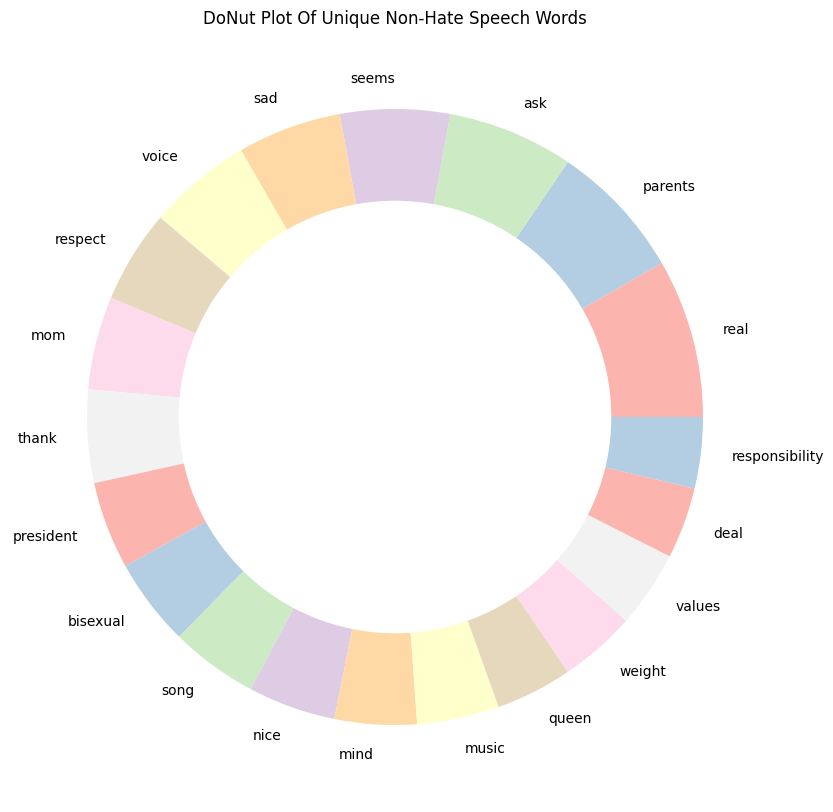

In [77]:
# For non-hate speech
visualizer.visualize_unique_words_donut(0, 20, colors=plt.cm.Pastel1.colors)

In [78]:
print("The top 20 unique words in Hate Speech are:")
unique_negative.style.background_gradient(cmap='Greens')

The top 20 unique words in Hate Speech are:


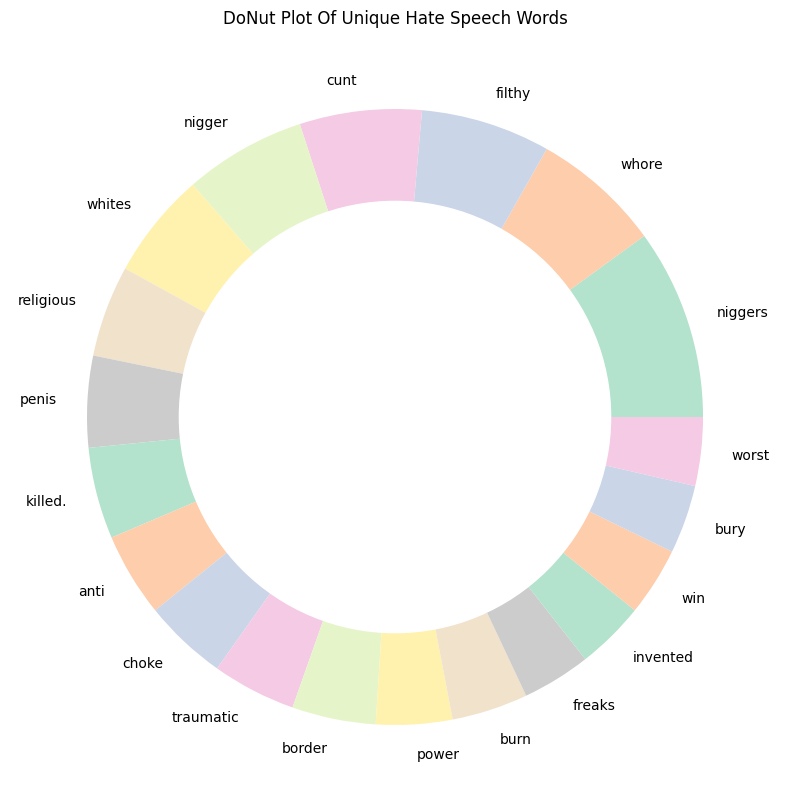

In [79]:
# For hate speech
visualizer.visualize_unique_words_donut(1, 20, colors=plt.cm.Pastel2.colors)

## Word count 

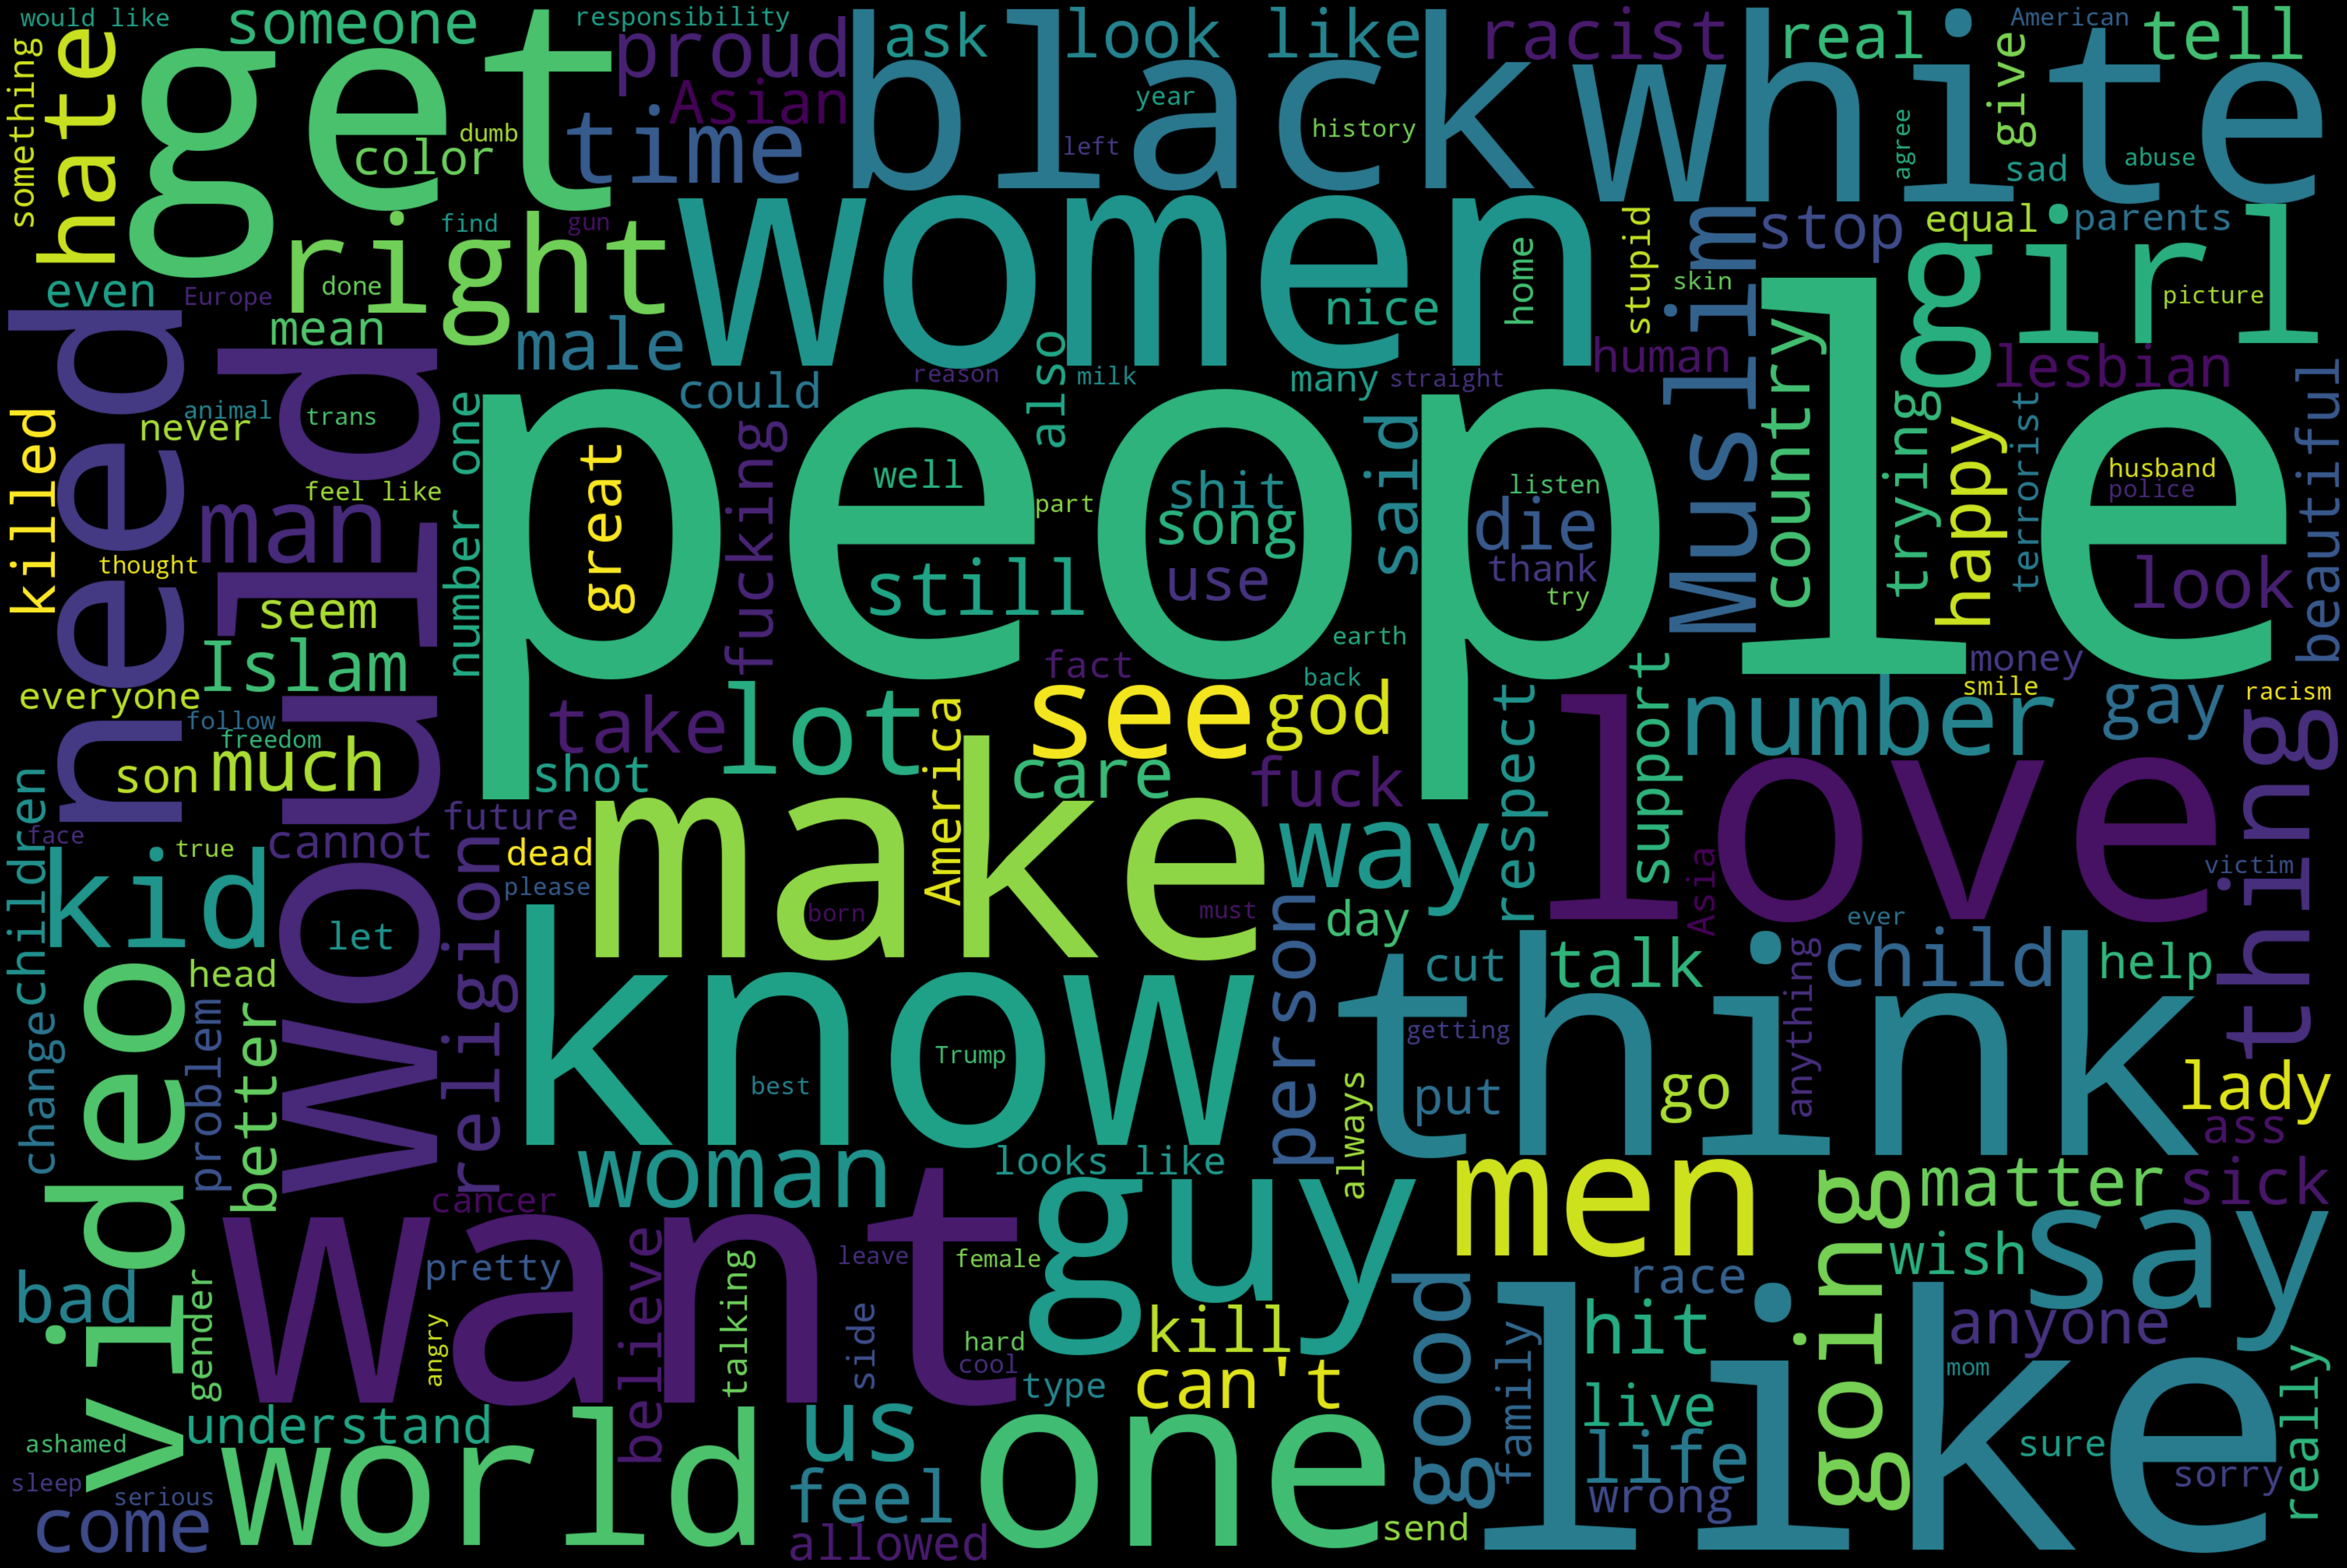

In [80]:
visualizer.generate_wordcloud_non_hate()

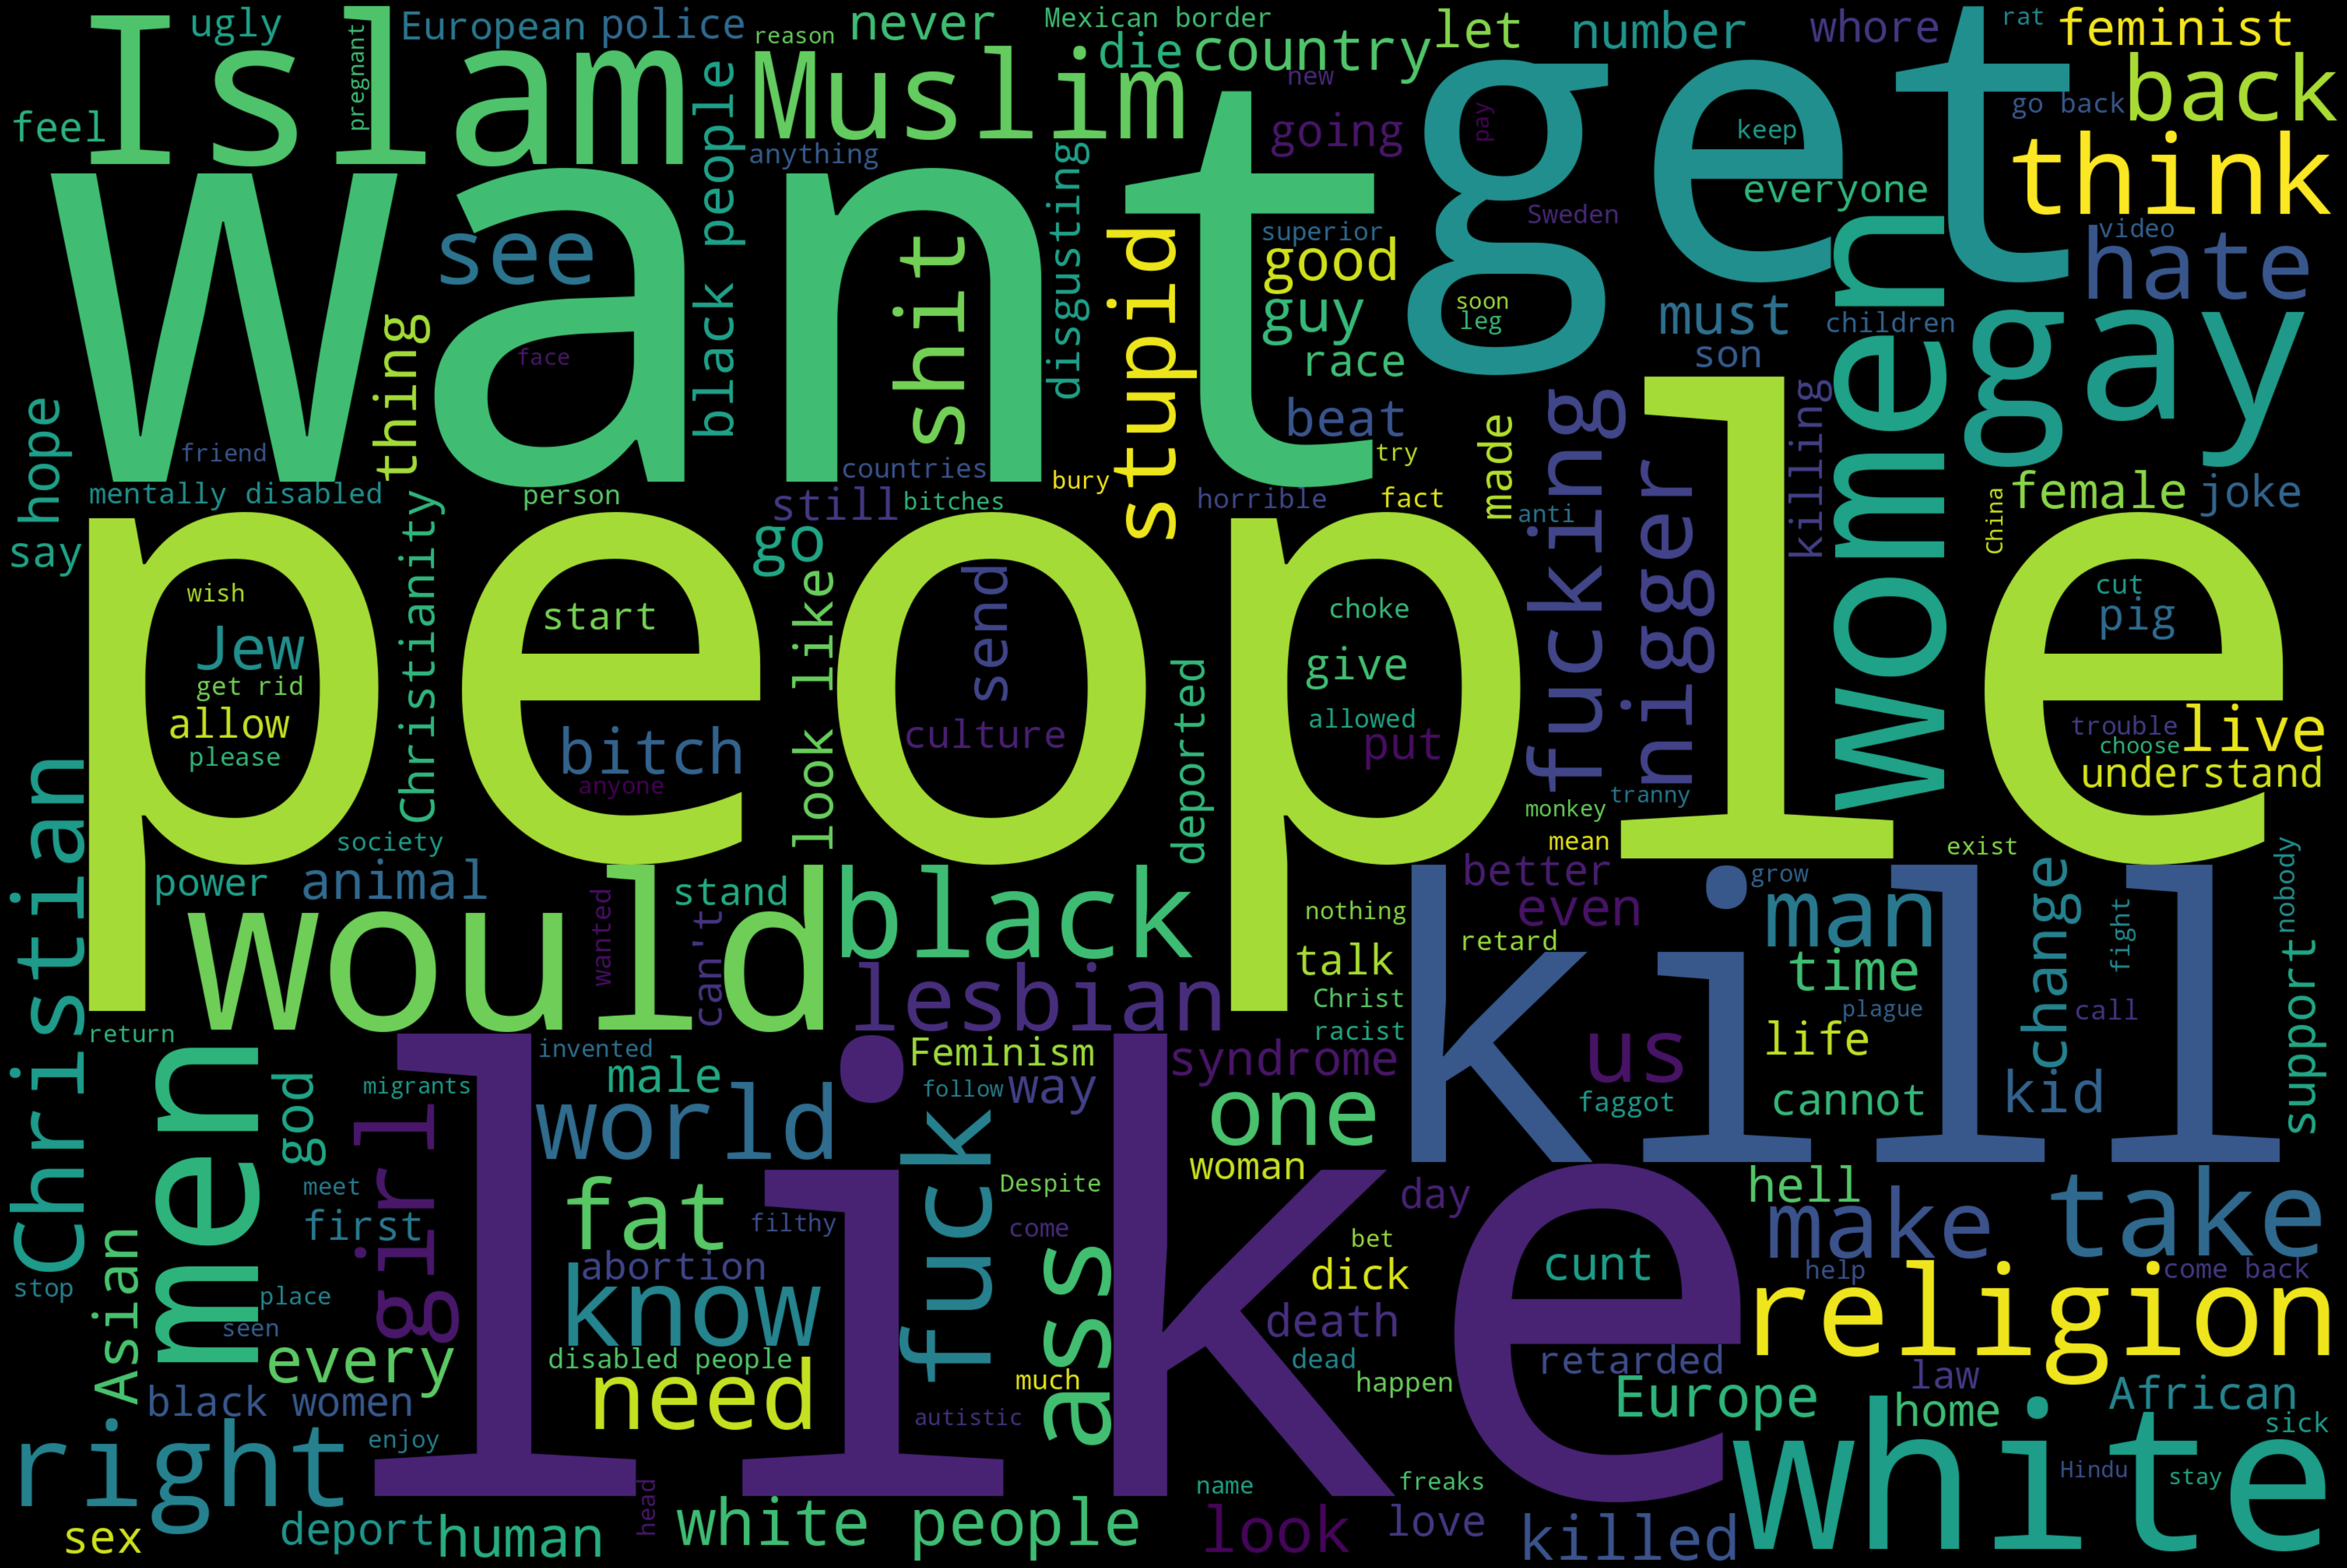

In [81]:
visualizer.generate_wordcloud_hate()

In [82]:
visualizer.visualize_polarity_distribution()

In [83]:
visualizer.visualize_review_length_distribution()

In [84]:
visualizer.visualize_word_count_distribution()

In [91]:
df = df[['cleaned_comment', 'class']]

# 5. Data modeling

### First step : is to create embeddings from our comments so that these embeddings will be later passed to different models 

## We'll start with bert embeddings

In [170]:
df = pd.read_csv('./Data/pegasus_data.csv')
df = df[['cleaned_comment', 'class']]

In [171]:
traindata,testdata=train_test_split(df,test_size=0.2,random_state=42)
print('Data shapes :',traindata.shape,testdata.shape)

Data shapes : (2948, 2) (738, 2)


In [172]:
train_comments = traindata['cleaned_comment'].values.tolist()
train_labels = traindata['class'].values.tolist()
test_comments = testdata['cleaned_comment'].values.tolist()
test_labels = testdata['class'].values.tolist()

train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [173]:
print('Comments len :')
print('----')
print('train_comments',len(train_comments))
print('test_comments',len(test_comments))
print('valid_comments',len(val_comments))
print('----')

Comments len :
----
train_comments 2653
test_comments 738
valid_comments 295
----


### Generate bert embedding

In [174]:
# Instance of bert embeddings
BertEmbed=BertEmbedding(train_comments, test_comments, val_comments)

In [175]:
tokenizer, train_embeddings, val_embeddings, test_embeddings =  BertEmbed.generate_bert_embeddings()

In [176]:
#Create train dataframe
dfinter = []
for emb, label in zip(train_embeddings, train_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
traindata = pd.DataFrame(dfinter)
print(traindata.shape)
traindata.head(4)

(2653, 2)


comment_embedding  label
0  [0.22550988, 0.39024884, 0.4869176, 0.3586974,...      1
1  [-0.06585185, -0.060144704, 0.05662379, 0.0625...      0
2  [-0.122529626, 0.40650278, -0.27360538, -0.212...      1
3  [0.10199389, 0.078111894, 0.20343138, -0.33077...      0

In [177]:
#Create test dataframe
dfinter = []
for emb, label in zip(test_embeddings, test_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
testdata = pd.DataFrame(dfinter)
print(testdata.shape)
testdata.head(4)

(738, 2)


comment_embedding  label
0  [0.22439966, 0.36096308, 0.09895055, 0.1442883...      0
1  [0.2107291, 0.05618518, 0.19700702, -0.1029363...      0
2  [-0.077766, -0.10448319, -0.53871477, -0.37174...      0
3  [-0.0023392928, 0.5973695, -0.39766195, -0.128...      0

In [178]:
#Create val dataframe
dfinter = []
for emb, label in zip(val_embeddings, val_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
valdata = pd.DataFrame(dfinter)
print(valdata.shape)
valdata.head(4)

(295, 2)


comment_embedding  label
0  [0.032151792, 0.72225183, -0.6718182, -0.17263...      1
1  [-0.9118341, -0.15891144, -0.6649435, -0.19420...      0
2  [-0.19986604, 0.6030543, -0.5454061, -0.282015...      1
3  [0.25395834, -0.2439524, -0.31541064, 0.040028...      0

In [179]:
traindata.to_csv('./Data/traindata_bert.csv', index=False)
testdata.to_csv('./Data/testdata_bert.csv', index=False)
valdata.to_csv('./Data/valdata_bert.csv', index=False)


In [180]:
traindata

comment_embedding  label
0     [0.22550988, 0.39024884, 0.4869176, 0.3586974,...      1
1     [-0.06585185, -0.060144704, 0.05662379, 0.0625...      0
2     [-0.122529626, 0.40650278, -0.27360538, -0.212...      1
3     [0.10199389, 0.078111894, 0.20343138, -0.33077...      0
4     [0.053351138, 0.30333793, -0.38442755, -0.2415...      0
...                                                 ...    ...
2648  [0.104842916, 0.345439, -0.42575026, 0.1982044...      1
2649  [-0.043238528, 0.6049166, -0.5467371, -0.23667...      1
2650  [-0.09303558, 0.036842726, -0.24754632, -0.163...      0
2651  [0.037789606, 0.25245136, -0.3434361, 0.045162...      0
2652  [-0.0354088, 0.6183956, -0.5012398, -0.1996424...      1

[2653 rows x 2 columns]

### Now after generating the embeddings we're going to use them for modeling

#### CNN

In [181]:
#Get data
train_data, val_data, test_data = load_data(traindata, valdata, testdata)

cnn_model = CNN(768,2)

# Entraînement du modèle
trainer = Model_training(cnn_model, train_data, val_data,epochs=20)
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train()

Epoch [20/20], Train Loss: 0.1567, Val Loss: 0.2477, Train Acc: 0.9306, Val Acc: 0.8983


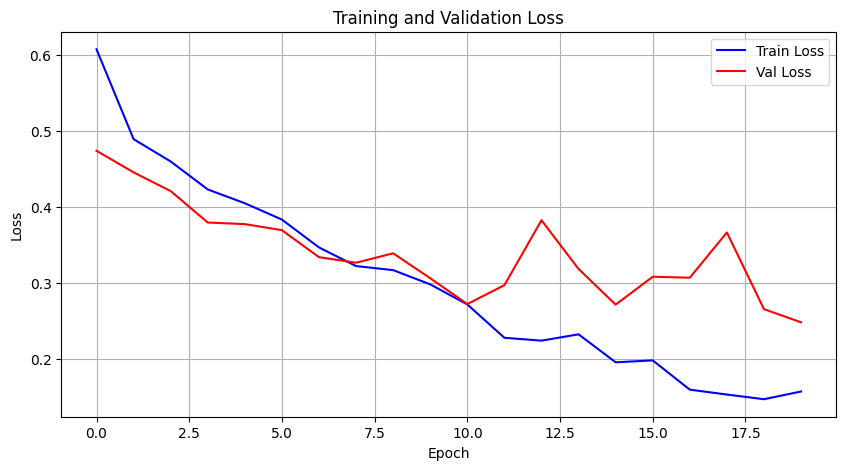

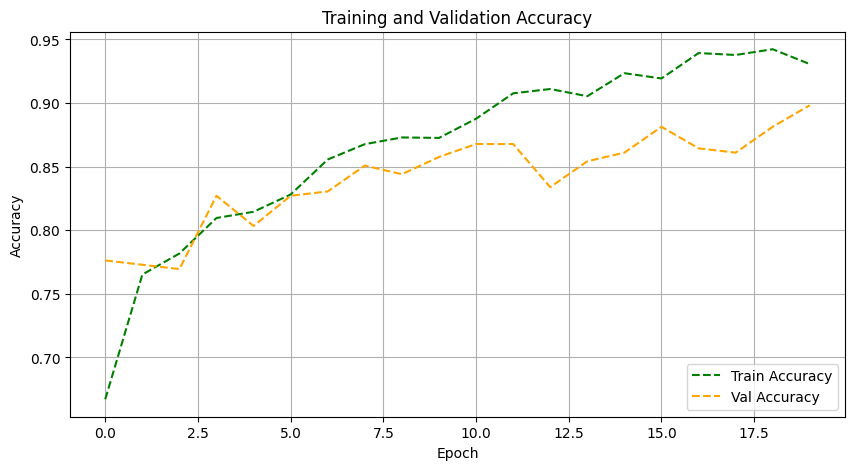

In [182]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Accuracy 0.8591, Precision: 0.8554, Recall: 0.8504, F1-score: 0.8527

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       440
           1       0.84      0.81      0.82       298

    accuracy                           0.86       738
   macro avg       0.86      0.85      0.85       738
weighted avg       0.86      0.86      0.86       738



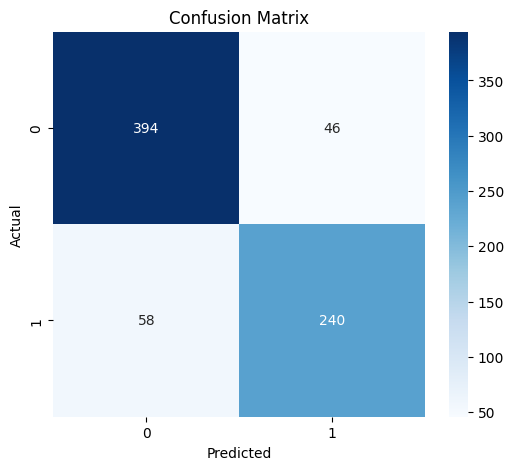

In [183]:
# Evaluation
# évaluation du modèle
evaluate_cnn_model(cnn_model, test_data)


#### LSTM

In [184]:
lstm_classifier = LSTMClassifier(tokenizer)

In [185]:
history = lstm_classifier.train_model(
    traindata,  
    testdata,   
    epochs=40,
    batch_size=32
)

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - Precision: 0.4413 - Recall: 0.5773 - accuracy: 0.5600 - loss: 0.8213 - val_Precision: 0.8395 - val_Recall: 0.2282 - val_accuracy: 0.6707 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - Precision: 0.5918 - Recall: 0.7282 - accuracy: 0.6997 - loss: 0.5893 - val_Precision: 0.8676 - val_Recall: 0.1980 - val_accuracy: 0.6640 - val_loss: 0.6510 - learning_rate: 1.0000e-04
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - Precision: 0.6656 - Recall: 0.7712 - accuracy: 0.7587 - loss: 0.5053 - val_Precision: 0.7040 - val_Recall: 0.6544 - val_accuracy: 0.7493 - val_loss: 0.6104 - learning_rate: 1.0000e-04
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - Precision: 0.6896 - Recall: 0.7608 - accuracy: 0.7731 - loss: 0.4836 - val_Precision: 0.7374 - val_Recall: 0.6879 - val_accuracy: 0.7751 - val_loss: 0.5428 - learning_rate: 1.0000e-04
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step 

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy: 0.8794, Precision: 0.8770, Recall: 0.8712, F1-score: 0.8738

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       440
           1       0.87      0.83      0.85       298

    accuracy                           0.88       738
   macro avg       0.88      0.87      0.87       738
weighted avg       0.88      0.88      0.88       738



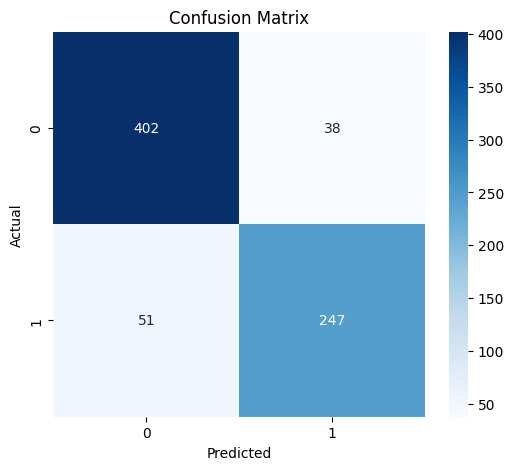

In [186]:
# Evaluate
lstm_classifier.evaluate_model(testdata)



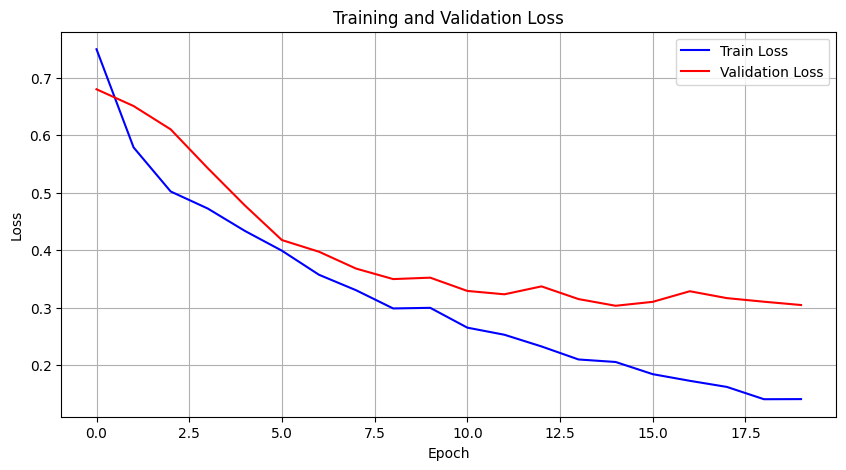

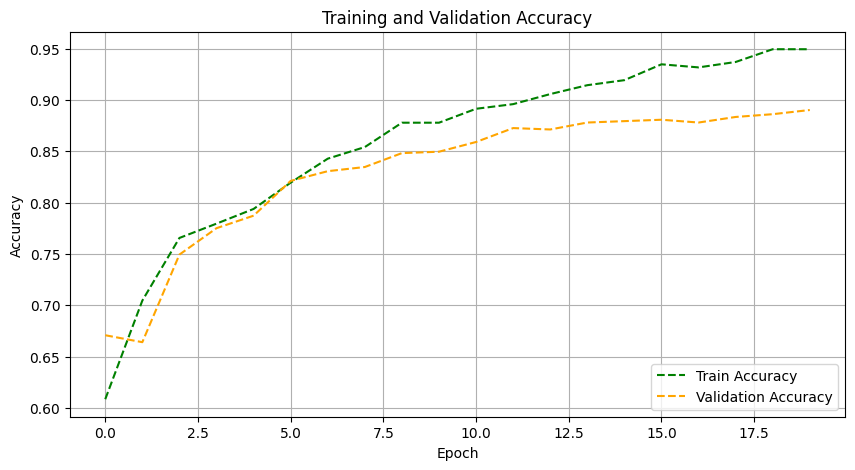

In [187]:
# Plot metrics
lstm_classifier.plot_metrics(history)


### SVM

In [188]:
X_train = np.array(traindata['comment_embedding'].tolist())
y_train = np.array(traindata['label'])

X_val = np.array(valdata['comment_embedding'].tolist())
y_val = np.array(valdata['label'])

X_test = np.array(testdata['comment_embedding'].tolist())
y_test = np.array(testdata['label'])

In [189]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [190]:
# Instanciation de l'objet SVMClassifier
svm_model = SVMClassifier(kernel='linear')

In [191]:
# Train SVM model
svm_model.train_model(X_train_resampled,y_train_resampled)

# Predict on test set
y_pred = svm_model.predict_data(X_test)


In [192]:
# Vérifier les performances après l'entraînement
train_accuracy = svm_model.model.score(X_train_resampled, y_train_resampled)
val_accuracy = svm_model.model.score(X_val, y_val)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 0.9565
Validation Accuracy: 0.8102


Accuracy: 0.8117, Precision: 0.8040, Recall: 0.8074, F1-score: 0.8055

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       440
           1       0.76      0.79      0.77       298

    accuracy                           0.81       738
   macro avg       0.80      0.81      0.81       738
weighted avg       0.81      0.81      0.81       738



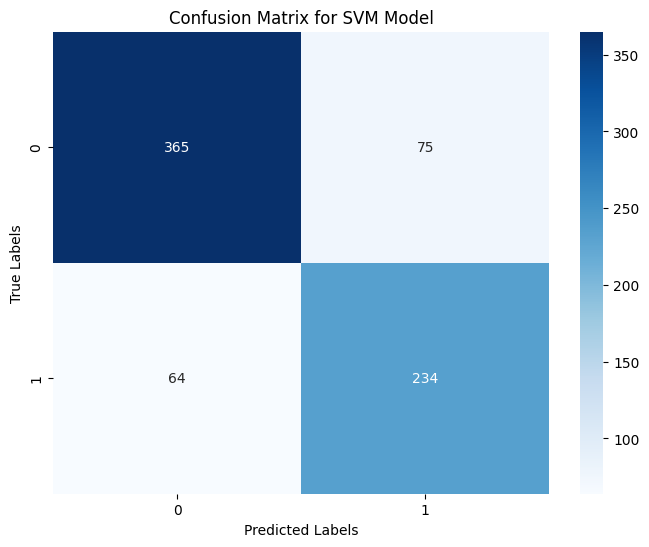

In [193]:
svm_model.evaluate_svm_model(X_test, y_test)

### KNN

In [194]:
knn_classifier = KNNClassifier()

In [195]:
# Train KNN model
knn_classifier.train_model(X_train_resampled,y_train_resampled)


Accuracy: 0.8699, Precision: 0.8686, Recall: 0.8595, F1-score: 0.8633

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       440
           1       0.86      0.81      0.83       298

    accuracy                           0.87       738
   macro avg       0.87      0.86      0.86       738
weighted avg       0.87      0.87      0.87       738



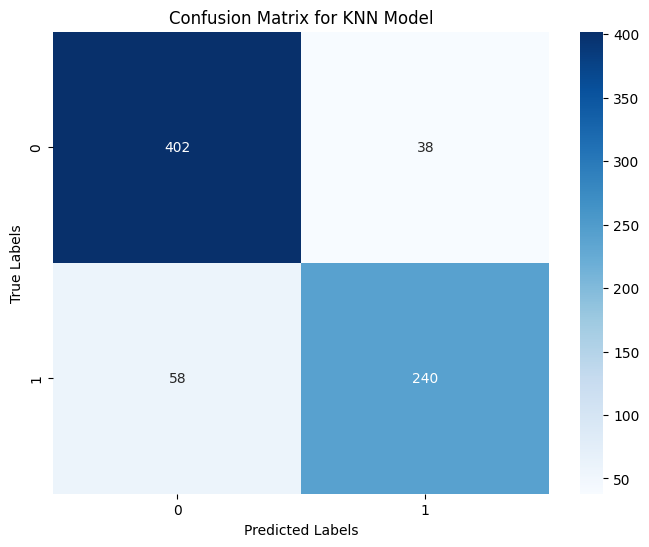

In [196]:
knn_classifier.evaluate_knn_model(X_test, y_test)

### Xgboost

Accuracy: 0.8388, Precision: 0.8333, Recall: 0.8307, F1-score: 0.8319

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       440
           1       0.81      0.79      0.80       298

    accuracy                           0.84       738
   macro avg       0.83      0.83      0.83       738
weighted avg       0.84      0.84      0.84       738



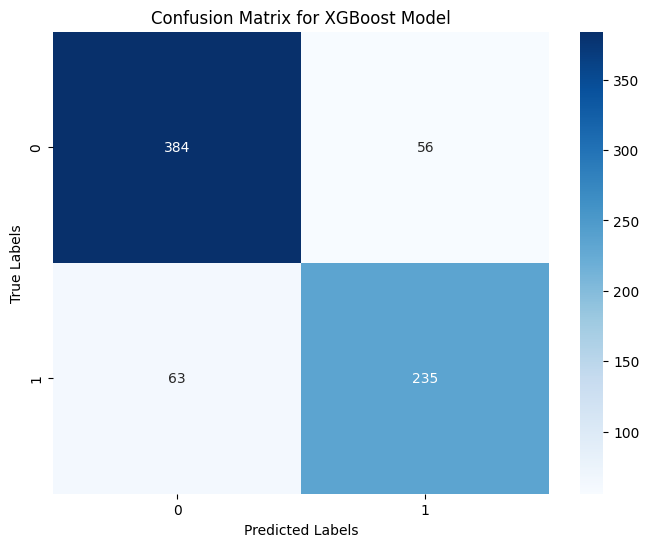

In [197]:

# Création de l'instance du classifieur XGBoost avec les hyperparamètres par défaut
xgboost_classifier = XGBoostClassifier(learning_rate=0.05, n_estimators=200, max_depth=5)

# Entraînement du modèle
xgboost_classifier.train_model(X_train_resampled, y_train_resampled)

# Évaluation du modèle
xgboost_classifier.evaluate_xgboost_model(X_test, y_test)


## Hard Voting

In [198]:
# Initialize the HardVotingClassifier with all five models
hard_voting_model = HardVotingClassifier(
    svm_model=svm_model,
    knn_model=knn_classifier,
    lstm_model=lstm_classifier,
    cnn_model=cnn_model,
    xgboost_model=xgboost_classifier
)

# Convert validation data to PyTorch tensor for CNN
val_inputs_tensor = torch.tensor(X_val, dtype=torch.float32)

# Perform predictions using the hard voting model
y_pred = hard_voting_model.predict(X_val, X_val, val_inputs_tensor)

# Evaluate the model performance (e.g., accuracy)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Hard Voting Classifier: {accuracy:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy of Hard Voting Classifier: 0.9119


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       182
           1       0.89      0.88      0.88       113

    accuracy                           0.91       295
   macro avg       0.91      0.91      0.91       295
weighted avg       0.91      0.91      0.91       295


Confusion Matrix:


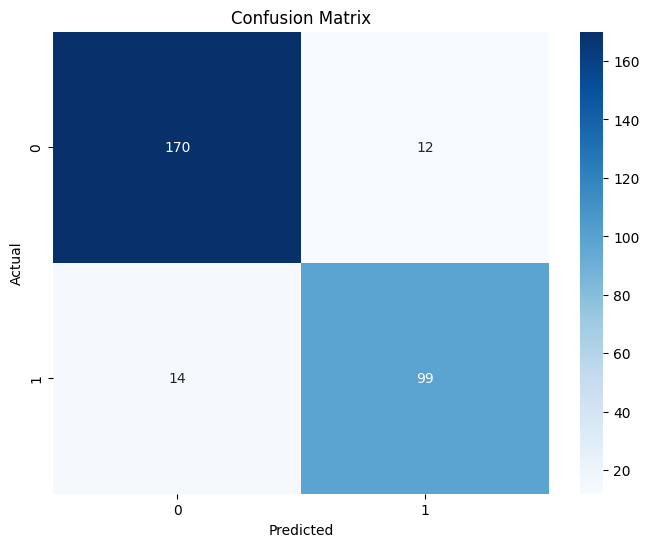

In [199]:
# Evaluate the model with the provided validation data
hard_voting_model.evaluate(X_val, X_val, val_inputs_tensor, y_val)

In [116]:
# List of models
models = ['hard_voting', 'svm', 'knn', 'lstm', 'cnn', 'xgboost']

# Model instances
the_models = {
    'hard_voting': hard_voting_model,
    'svm': svm_model,
    'knn': knn_classifier,
    'lstm': lstm_classifier,
    'cnn': cnn_model,
    'xgboost': xgboost_classifier
}

# Instantiate and evaluate

model_evaluator = ModelEvaluator(models, the_models, X_val, X_val, val_inputs_tensor, y_val)
model_evaluator.evaluate_models()
print('---Accuracy with bert---')
accuracy_df = model_evaluator.display_results()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
---Accuracy with bert---
         Model  Accuracy
0  hard_voting  0.898305
1          svm  0.810169
2          knn  0.864407
3         lstm  0.911864
4          cnn  0.844068
5      xgboost  0.884746


### Now we're going to use Deberta for embeddings

In [117]:
# Instance of bert deberta embeddings
DebertaEmbed=DebertaEmbedding(train_comments, test_comments, val_comments)

In [118]:
tokenizer, train_embeddings, val_embeddings, test_embeddings =  DebertaEmbed.generate_deberta_embeddings()

In [119]:
#Create train dataframe
dfinter = []
for emb, label in zip(train_embeddings, train_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
traindata = pd.DataFrame(dfinter)
print(traindata.shape)
traindata.head(4)

(2653, 2)


comment_embedding  label
0  [0.057025317, -0.035139453, -0.086753584, -0.0...      1
1  [0.05713572, -0.04121634, -0.096727036, -0.047...      0
2  [0.07127284, -0.036056582, -0.085357994, -0.02...      1
3  [0.05598719, -0.031536303, -0.08330167, -0.036...      0

In [120]:
#Create test dataframe
dfinter = []
for emb, label in zip(test_embeddings, test_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
testdata = pd.DataFrame(dfinter)
print(testdata.shape)
testdata.head(4)

(738, 2)


comment_embedding  label
0  [0.06711297, -0.027603678, -0.07369609, -0.032...      0
1  [0.069010794, -0.03568412, -0.089948766, -0.02...      0
2  [0.065336116, -0.024178877, -0.09278985, -0.02...      0
3  [0.058812793, -0.028473567, -0.08841404, -0.02...      0

In [121]:
#Create val dataframe
dfinter = []
for emb, label in zip(val_embeddings, val_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
valdata = pd.DataFrame(dfinter)
print(valdata.shape)
valdata.head(4)

(295, 2)


comment_embedding  label
0  [0.061430797, -0.043504562, -0.08283397, -0.03...      1
1  [0.055142123, -0.03202818, -0.081878416, -0.03...      0
2  [0.059202023, -0.034646597, -0.08298477, -0.02...      1
3  [0.054631352, -0.033516224, -0.07662344, -0.02...      0

In [122]:
traindata.to_csv('./Data/traindata_debertberta.csv', index=False)
testdata.to_csv('./Data/testdata_deberta.csv', index=False)
valdata.to_csv('./Data/valdata_bert.csv', index=False)


### CNN

In [123]:
#Get data
train_data, val_data, test_data = load_data(traindata, valdata, testdata)

cnn_model = CNN(768,2)

# Entraînement du modèle
trainer = Model_training(cnn_model, train_data, val_data,epochs=20)
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train()

Epoch [20/20], Train Loss: 0.5594, Val Loss: 0.5096, Train Acc: 0.7098, Val Acc: 0.7627


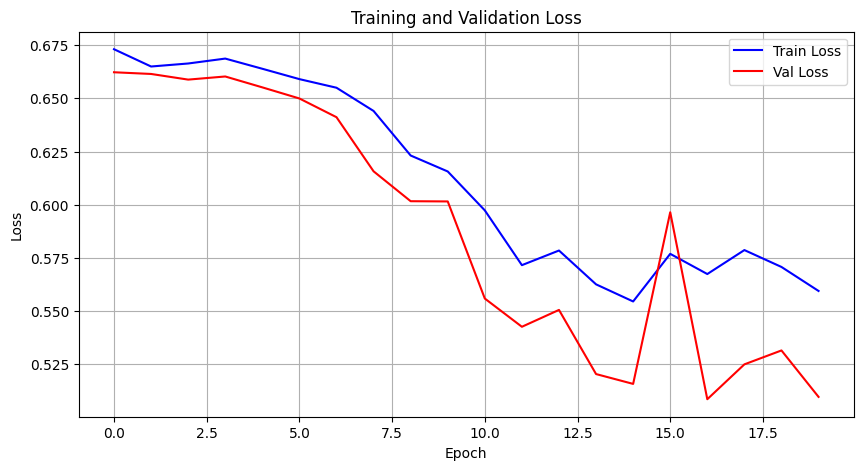

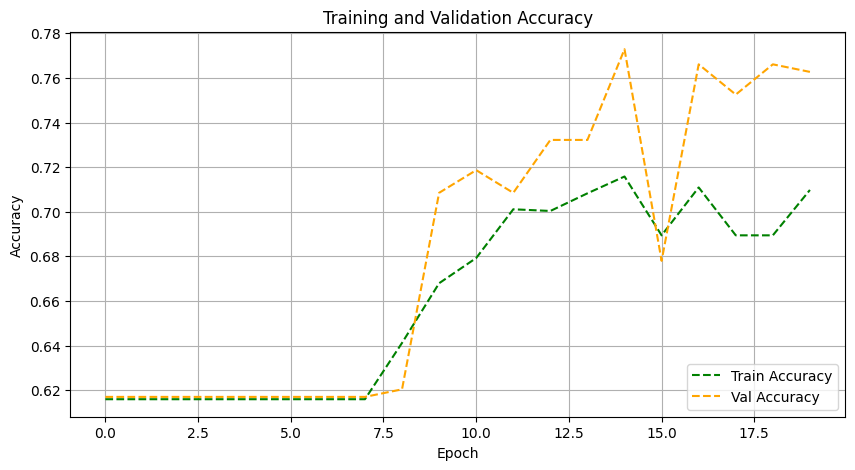

In [124]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Accuracy 0.7344, Precision: 0.7349, Recall: 0.7020, F1-score: 0.7075

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80       440
           1       0.74      0.53      0.62       298

    accuracy                           0.73       738
   macro avg       0.73      0.70      0.71       738
weighted avg       0.73      0.73      0.72       738



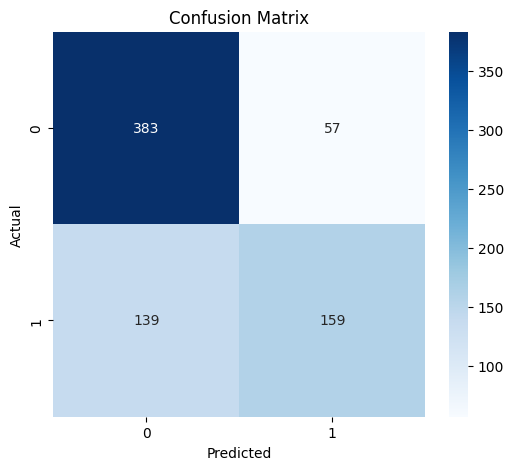

In [125]:
# Evaluation
evaluate_cnn_model(cnn_model, test_data)


### LSTM

In [126]:
lstm_classifier = LSTMClassifier(tokenizer)

In [127]:
history = lstm_classifier.train_model(
    traindata,  
    testdata,   
    epochs=40,
    batch_size=32
)

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - Precision: 0.4652 - Recall: 0.5601 - accuracy: 0.5726 - loss: 0.7880 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - Precision: 0.5553 - Recall: 0.6953 - accuracy: 0.6789 - loss: 0.6072 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6771 - learning_rate: 1.0000e-04
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - Precision: 0.6160 - Recall: 0.7094 - accuracy: 0.7151 - loss: 0.5554 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6741 - learning_rate: 1.0000e-04
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - Precision: 0.6395 - Recall: 0.7309 - accuracy: 0.7367 - loss: 0.5202 - val_Precision: 1.0000 - val_Recall: 0.0168 - val_accuracy: 0.6030 - val_loss: 0.6653 - learning_rate: 1.0000e-04
Epoch 5/40
83/83 ━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.8157, Precision: 0.8100, Recall: 0.8048, F1-score: 0.8071

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       440
           1       0.79      0.75      0.77       298

    accuracy                           0.82       738
   macro avg       0.81      0.80      0.81       738
weighted avg       0.81      0.82      0.81       738



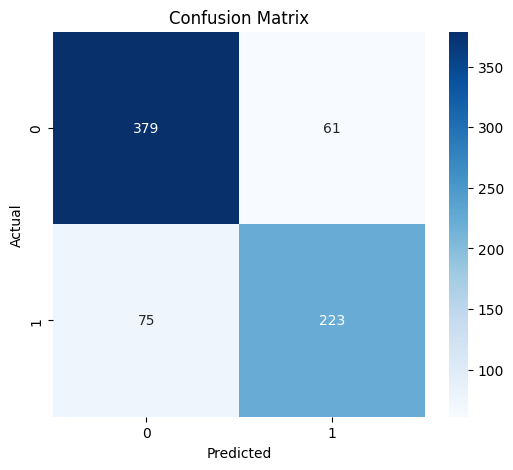

In [128]:
# Evaluate
lstm_classifier.evaluate_model(testdata)

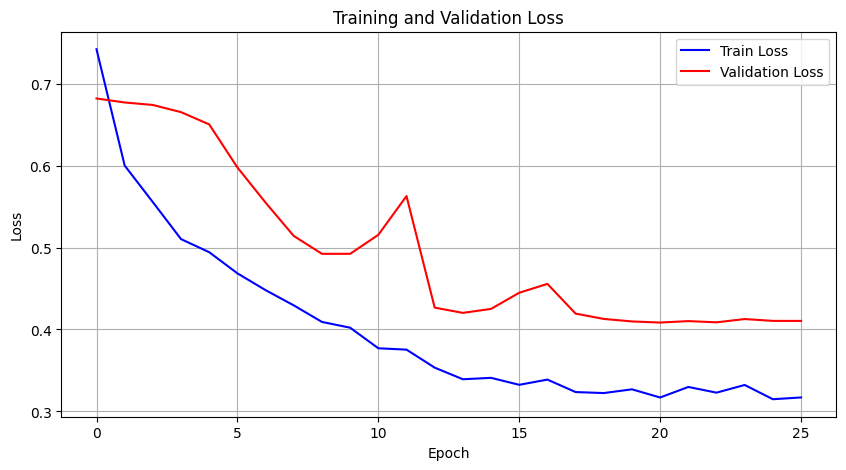

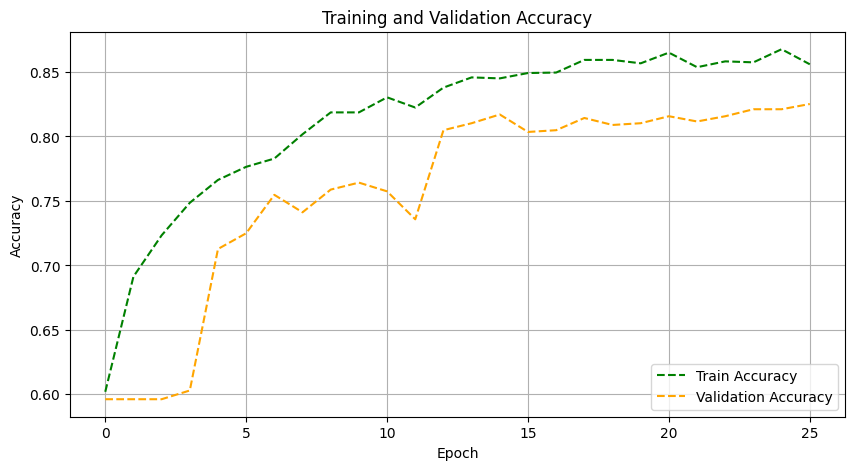

In [129]:
# Plot metrics
lstm_classifier.plot_metrics(history)

### SVM

In [130]:
X_train = np.array(traindata['comment_embedding'].tolist())
y_train = np.array(traindata['label'])

X_val = np.array(valdata['comment_embedding'].tolist())
y_val = np.array(valdata['label'])

X_test = np.array(testdata['comment_embedding'].tolist())
y_test = np.array(testdata['label'])

In [131]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [132]:
# Instanciation de l'objet SVMClassifier
svm_model = SVMClassifier(kernel='linear')

In [133]:
# Train SVM model
svm_model.train_model(X_train_resampled,y_train_resampled)

# Predict on test set
y_pred = svm_model.predict_data(X_test)


In [134]:
# Vérifier les performances après l'entraînement
train_accuracy = svm_model.model.score(X_train_resampled, y_train_resampled)
val_accuracy = svm_model.model.score(X_val, y_val)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 0.7589
Validation Accuracy: 0.7559


Accuracy: 0.7046, Precision: 0.7006, Recall: 0.7079, F1-score: 0.7003

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       440
           1       0.61      0.72      0.66       298

    accuracy                           0.70       738
   macro avg       0.70      0.71      0.70       738
weighted avg       0.72      0.70      0.71       738



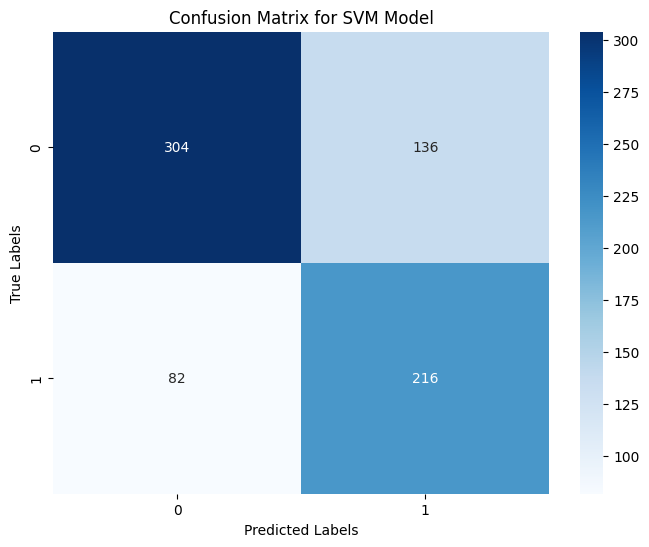

In [135]:
svm_model.evaluate_svm_model(X_test, y_test)

### KNN 

In [136]:
knn_classifier = KNNClassifier(n_neighbors=3)

In [137]:
# Train KNN model
knn_classifier.train_model(X_train_resampled,y_train_resampled)


Accuracy: 0.7060, Precision: 0.7249, Recall: 0.7285, F1-score: 0.7058



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       440
           1       0.60      0.85      0.70       298

    accuracy                           0.71       738
   macro avg       0.72      0.73      0.71       738
weighted avg       0.75      0.71      0.71       738



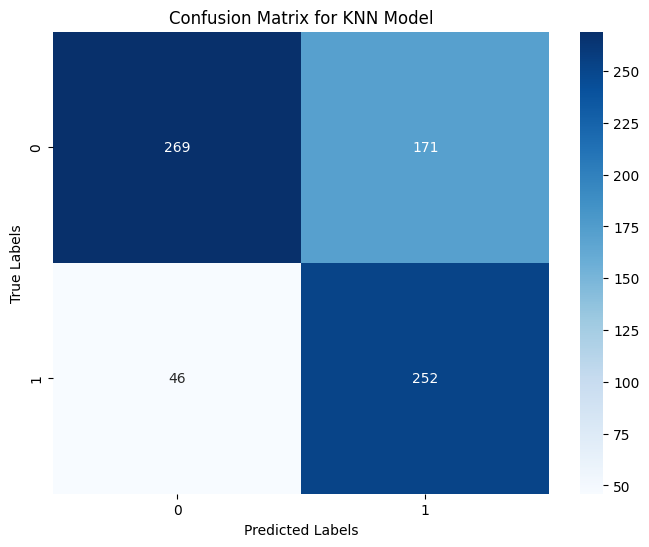

In [138]:
knn_classifier.evaluate_knn_model(X_test, y_test)

### Xgboost

Accuracy: 0.8252, Precision: 0.8179, Recall: 0.8220, F1-score: 0.8197

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       440
           1       0.77      0.81      0.79       298

    accuracy                           0.83       738
   macro avg       0.82      0.82      0.82       738
weighted avg       0.83      0.83      0.83       738



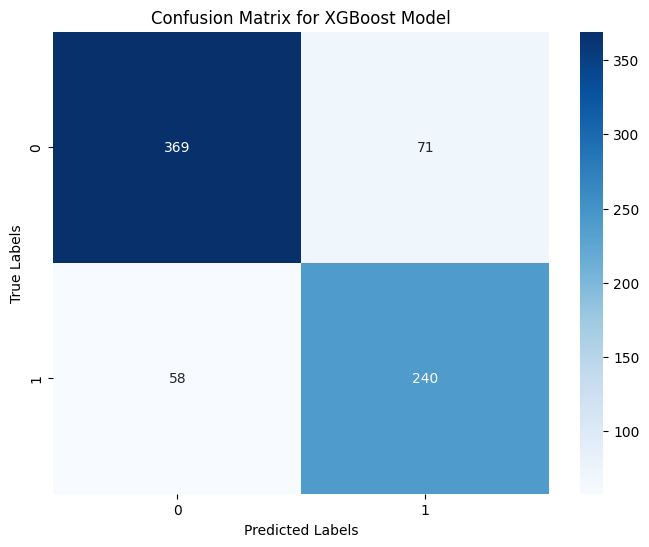

In [139]:
# Création de l'instance du classifieur XGBoost avec les hyperparamètres par défaut
xgboost_classifier = XGBoostClassifier(learning_rate=0.05, n_estimators=200, max_depth=5)

# Entraînement du modèle
xgboost_classifier.train_model(X_train_resampled, y_train_resampled)

# Évaluation du modèle
xgboost_classifier.evaluate_xgboost_model(X_test, y_test)


### Hard Voting

In [140]:
# Initialize the HardVotingClassifier with all five models
hard_voting_model = HardVotingClassifier(
    svm_model=svm_model,
    knn_model=knn_classifier,
    lstm_model=lstm_classifier,
    cnn_model=cnn_model,
    xgboost_model=xgboost_classifier
)

# Convert validation data to PyTorch tensor for CNN
val_inputs_tensor = torch.tensor(X_val, dtype=torch.float32)

# Perform predictions using the hard voting model
y_pred = hard_voting_model.predict(X_val, X_val, val_inputs_tensor)

# Evaluate the model performance (e.g., accuracy)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Hard Voting Classifier: {accuracy:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy of Hard Voting Classifier: 0.8305


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       182
           1       0.77      0.80      0.78       113

    accuracy                           0.83       295
   macro avg       0.82      0.82      0.82       295
weighted avg       0.83      0.83      0.83       295


Confusion Matrix:


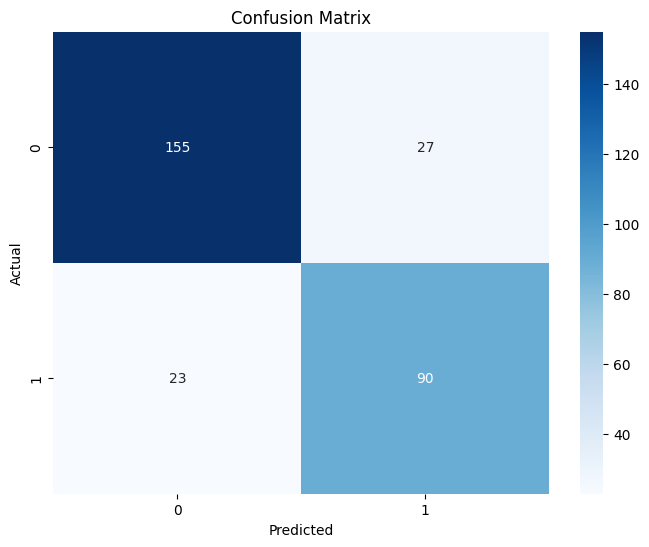

In [141]:
# Evaluate the model with the provided validation data
hard_voting_model.evaluate(X_val, X_val, val_inputs_tensor, y_val)

In [142]:
# List of models
models = ['hard_voting', 'svm', 'knn', 'lstm', 'cnn', 'xgboost']

# Model instances
the_models = {
    'hard_voting': hard_voting_model,
    'svm': svm_model,
    'knn': knn_classifier,
    'lstm': lstm_classifier,
    'cnn': cnn_model,
    'xgboost': xgboost_classifier
}

# Instantiate and evaluate

model_evaluator = ModelEvaluator(models, the_models, X_val, X_val, val_inputs_tensor, y_val)
model_evaluator.evaluate_models()
print('---Accuracy with deberta---')
accuracy_df = model_evaluator.display_results()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
---Accuracy with deberta---
         Model  Accuracy
0  hard_voting  0.830508
1          svm  0.755932
2          knn  0.698305
3         lstm  0.861017
4          cnn  0.762712
5      xgboost  0.840678


### Now we're going to use Roberta for embeddings

In [143]:
# Instance of bert embeddings
RobertaEmbed=RobertaEmbedding(train_comments, test_comments, val_comments)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [144]:
tokenizer, train_embeddings, val_embeddings, test_embeddings =  RobertaEmbed.generate_roberta_embeddings()

In [145]:
#Create train dataframe
dfinter = []
for emb, label in zip(train_embeddings, train_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
traindata = pd.DataFrame(dfinter)
print(traindata.shape)
traindata.head(4)

(2653, 2)


comment_embedding  label
0  [-0.045604423, 0.0820765, -0.018952738, -0.129...      1
1  [-0.12793247, 0.12414214, -0.009042662, -0.119...      0
2  [-0.09087445, 0.09581774, -0.0041828174, -0.15...      1
3  [-0.07303871, 0.13169442, -0.001150215, -0.122...      0

In [146]:
#Create test dataframe
dfinter = []
for emb, label in zip(test_embeddings, test_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
testdata = pd.DataFrame(dfinter)
print(testdata.shape)
testdata.head(4)

(738, 2)


comment_embedding  label
0  [-0.056241676, 0.14827228, -0.019222952, -0.12...      0
1  [-0.10649897, 0.08658421, 0.023250723, -0.1125...      0
2  [-0.09445165, 0.11632615, 0.016059132, -0.1072...      0
3  [-0.10110071, 0.13555348, 0.001145687, -0.1509...      0

In [147]:
#Create val dataframe
dfinter = []
for emb, label in zip(val_embeddings, val_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
valdata = pd.DataFrame(dfinter)
print(valdata.shape)
valdata.head(4)

(295, 2)


comment_embedding  label
0  [-0.057961047, 0.11114329, 0.013681255, -0.112...      1
1  [-0.14637572, 0.1221676, -0.0054292157, -0.133...      0
2  [-0.07113166, 0.0963389, -0.0033682026, -0.117...      1
3  [-0.10809748, 0.10558228, -0.04522612, -0.1057...      0

In [148]:
traindata.to_csv('./Data/traindata_roberta.csv', index=False)
testdata.to_csv('./Data/testdata_roberta.csv', index=False)
valdata.to_csv('./Data/valdata_roberta.csv', index=False)


## CNN

In [149]:
#Get data
train_data, val_data, test_data = load_data(traindata, valdata, testdata)

cnn_model = CNN(768,2)

# Entraînement du modèle
trainer = Model_training(cnn_model, train_data, val_data,epochs=20)
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train()

Epoch [20/20], Train Loss: 0.3469, Val Loss: 0.3643, Train Acc: 0.8398, Val Acc: 0.8136


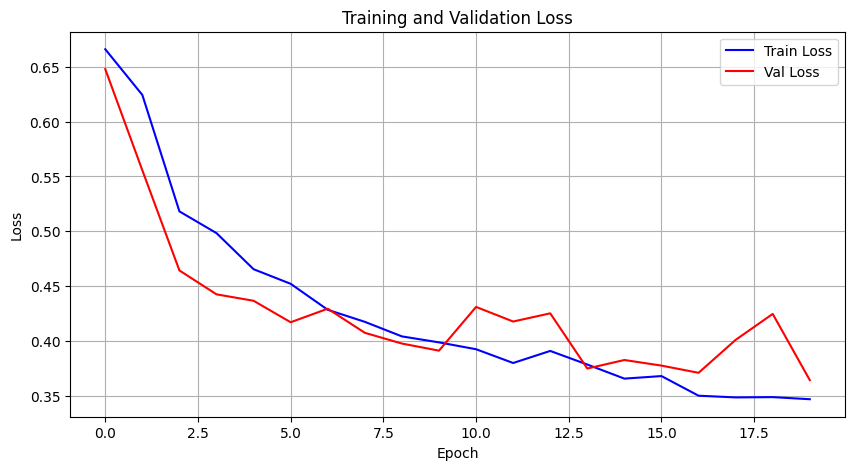

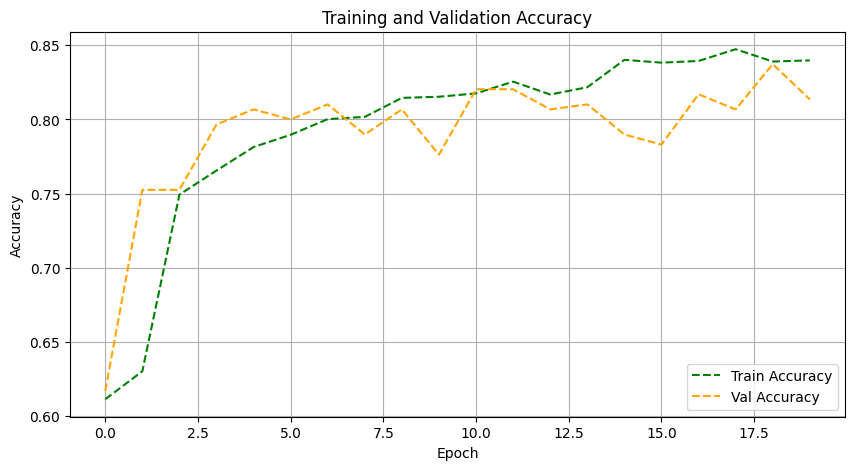

In [150]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Accuracy 0.7886, Precision: 0.8014, Recall: 0.7577, F1-score: 0.7667

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       440
           1       0.83      0.60      0.70       298

    accuracy                           0.79       738
   macro avg       0.80      0.76      0.77       738
weighted avg       0.80      0.79      0.78       738



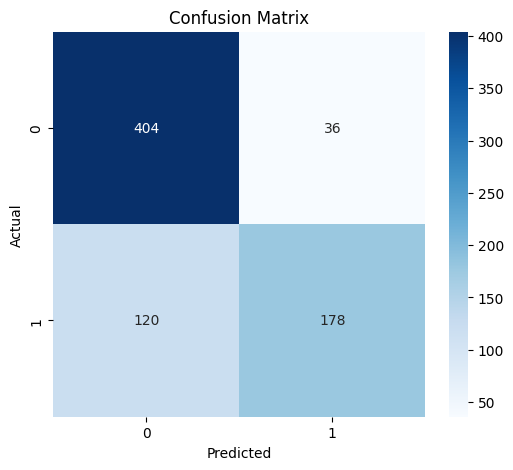

In [151]:
evaluate_cnn_model(cnn_model, test_data)


### LSTM

In [152]:
lstm_classifier = LSTMClassifier(tokenizer)

In [153]:
history = lstm_classifier.train_model(
    traindata,  
    testdata,   
    epochs=40,
    batch_size=32
)

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - Precision: 0.4338 - Recall: 0.5650 - accuracy: 0.5585 - loss: 0.7996 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6742 - learning_rate: 1.0000e-04
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - Precision: 0.6107 - Recall: 0.7059 - accuracy: 0.7052 - loss: 0.5895 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - Precision: 0.6528 - Recall: 0.7489 - accuracy: 0.7469 - loss: 0.5119 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6753 - learning_rate: 1.0000e-04
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - Precision: 0.7096 - Recall: 0.7474 - accuracy: 0.7768 - loss: 0.4779 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5962 - val_loss: 0.6679 - learning_rate: 1.0000e-04
Epoch 5/40
83/83 ━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy: 0.8550, Precision: 0.8500, Recall: 0.8481, F1-score: 0.8490

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       440
           1       0.83      0.81      0.82       298

    accuracy                           0.86       738
   macro avg       0.85      0.85      0.85       738
weighted avg       0.85      0.86      0.85       738



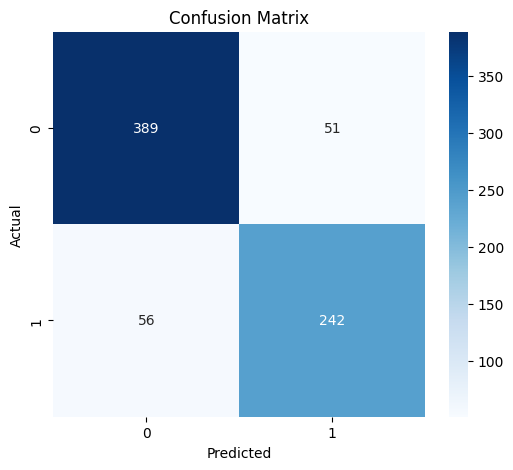

In [154]:
# Evaluate
lstm_classifier.evaluate_model(testdata)


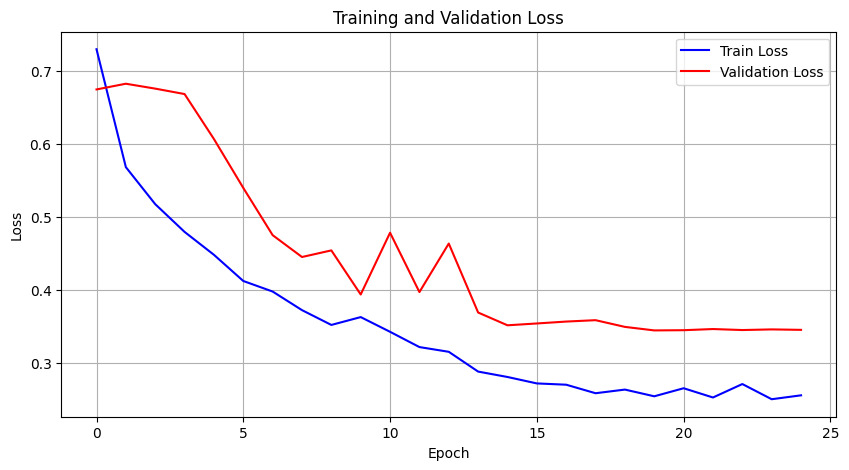

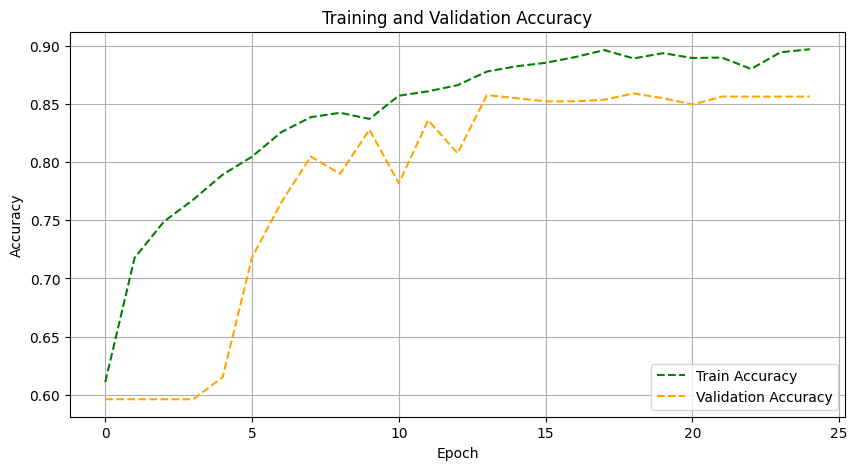

In [155]:
# Plot metrics
lstm_classifier.plot_metrics(history)


### SVM

In [156]:
X_train = np.array(traindata['comment_embedding'].tolist())
y_train = np.array(traindata['label'])

X_val = np.array(valdata['comment_embedding'].tolist())
y_val = np.array(valdata['label'])

X_test = np.array(testdata['comment_embedding'].tolist())
y_test = np.array(testdata['label'])

In [157]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [158]:
# Instanciation de l'objet SVMClassifier
svm_model = SVMClassifier(kernel='linear')

In [159]:
# Train SVM model
svm_model.train_model(X_train_resampled,y_train_resampled)

# Predict on test set
y_pred = svm_model.predict_data(X_test)

In [160]:
# Vérifier les performances après l'entraînement
train_accuracy = svm_model.model.score(X_train_resampled, y_train_resampled)
val_accuracy = svm_model.model.score(X_val, y_val)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 0.8574
Validation Accuracy: 0.8136


Accuracy: 0.8022, Precision: 0.7953, Recall: 0.8032, F1-score: 0.7977

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       440
           1       0.73      0.81      0.77       298

    accuracy                           0.80       738
   macro avg       0.80      0.80      0.80       738
weighted avg       0.81      0.80      0.80       738



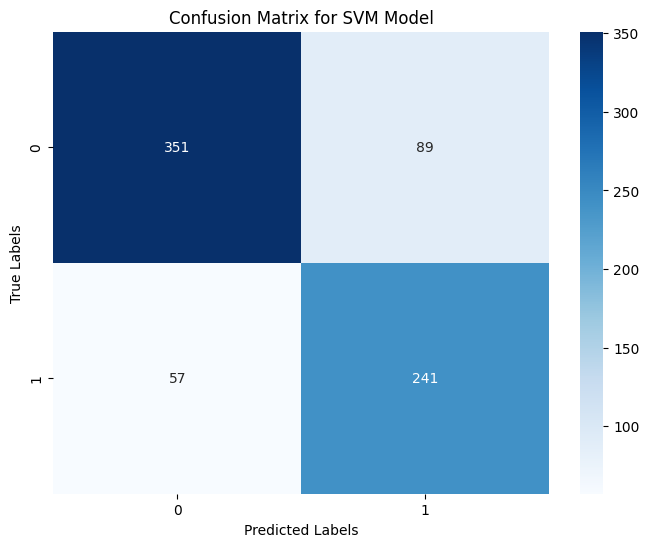

In [161]:
svm_model.evaluate_svm_model(X_test, y_test)

### KNN

In [162]:
knn_classifier = KNNClassifier(n_neighbors=2)

In [163]:
# Train KNN model
knn_classifier.train_model(X_train_resampled,y_train_resampled)


Accuracy: 0.8333, Precision: 0.8277, Recall: 0.8380, F1-score: 0.8302

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       440
           1       0.76      0.86      0.81       298

    accuracy                           0.83       738
   macro avg       0.83      0.84      0.83       738
weighted avg       0.84      0.83      0.83       738



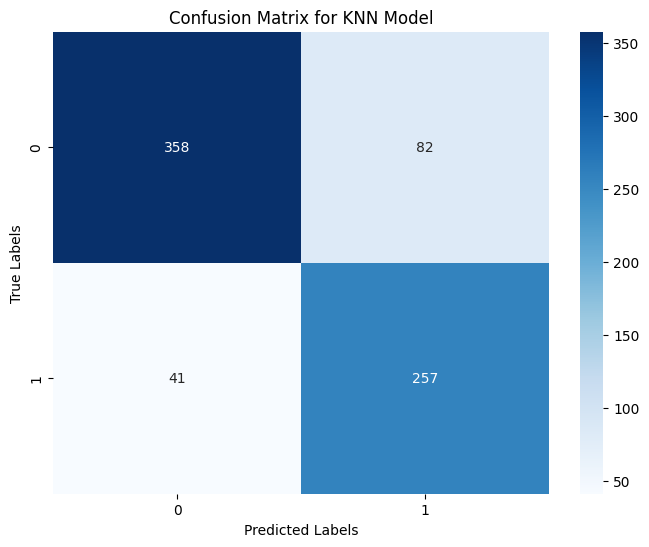

In [164]:
knn_classifier.evaluate_knn_model(X_test, y_test)

### Xgboost

Accuracy: 0.8401, Precision: 0.8351, Recall: 0.8313, F1-score: 0.8330

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       440
           1       0.81      0.79      0.80       298

    accuracy                           0.84       738
   macro avg       0.84      0.83      0.83       738
weighted avg       0.84      0.84      0.84       738



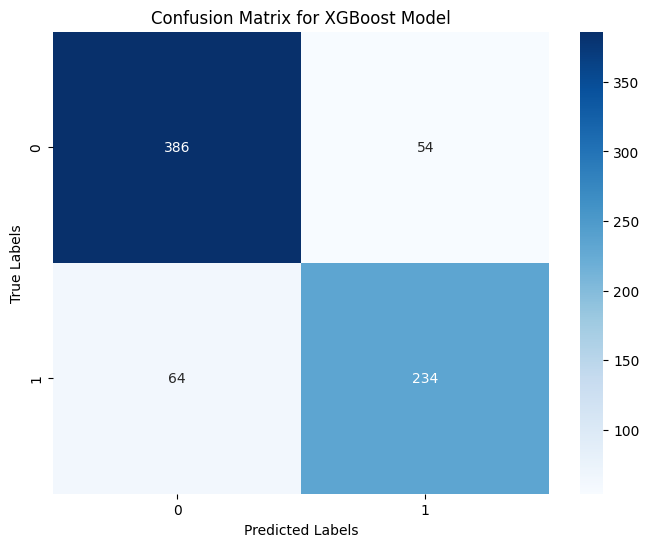

In [165]:
# Création de l'instance du classifieur XGBoost avec les hyperparamètres par défaut
xgboost_classifier = XGBoostClassifier(learning_rate=0.05, n_estimators=200, max_depth=5)

# Entraînement du modèle
xgboost_classifier.train_model(X_train_resampled, y_train_resampled)

# Évaluation du modèle
xgboost_classifier.evaluate_xgboost_model(X_test, y_test)


### Hard Voting

In [166]:
# Initialize the HardVotingClassifier with all five models
hard_voting_model = HardVotingClassifier(
    svm_model=svm_model,
    knn_model=knn_classifier,
    lstm_model=lstm_classifier,
    cnn_model=cnn_model,
    xgboost_model=xgboost_classifier
)

# Convert validation data to PyTorch tensor for CNN
val_inputs_tensor = torch.tensor(X_val, dtype=torch.float32)

# Perform predictions using the hard voting model
y_pred = hard_voting_model.predict(X_val, X_val, val_inputs_tensor)

# Evaluate the model performance (e.g., accuracy)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Hard Voting Classifier: {accuracy:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy of Hard Voting Classifier: 0.8847


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       182
           1       0.83      0.88      0.85       113

    accuracy                           0.88       295
   macro avg       0.88      0.88      0.88       295
weighted avg       0.89      0.88      0.89       295


Confusion Matrix:


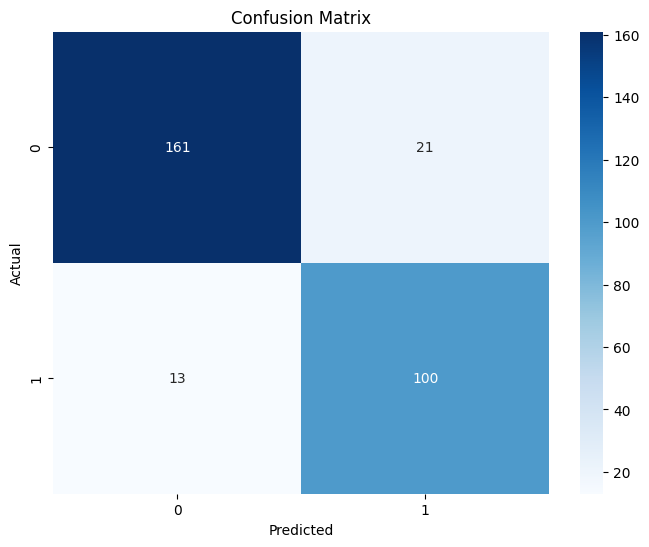

In [167]:
# Evaluate the model with the provided validation data
hard_voting_model.evaluate(X_val, X_val, val_inputs_tensor, y_val)

In [168]:
# List of models
models = ['hard_voting', 'svm', 'knn', 'lstm', 'cnn', 'xgboost']

# Model instances
the_models = {
    'hard_voting': hard_voting_model,
    'svm': svm_model,
    'knn': knn_classifier,
    'lstm': lstm_classifier,
    'cnn': cnn_model,
    'xgboost': xgboost_classifier
}

# Instantiate and evaluate
model_evaluator = ModelEvaluator(models, the_models, X_val, X_val, val_inputs_tensor, y_val)
model_evaluator.evaluate_models()
print('---Accuracy with roberta---')
accuracy_df = model_evaluator.display_results()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
---Accuracy with roberta---
         Model  Accuracy
0  hard_voting  0.884746
1          svm  0.813559
2          knn  0.877966
3         lstm  0.888136
4          cnn  0.813559
5      xgboost  0.871186


In [ ]:
# Save model and tokenizer
lstm_classifier.model.save("lstm_model.h5")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
